# Monocyte cluster

# 11 Nov 2021

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
import seaborn as sb
from itertools import compress
import random

sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]

In [2]:
sb.set_palette('deep')

In [3]:
# import utils
import sys
sys.path.append('/home/jovyan/chenqu_utils')
from array_operations import *
sys.path.append('/home/jovyan/thymusatlas/')
import scjp
from scjp import model

In [4]:
organ_order = ['YS','LI','BM','TH','SP','MLN','SK','GU','KI']

In [5]:
# set working directory
%cd /home/jovyan/panfetal/

/home/jovyan/panfetal


In [6]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/Pan_fetal/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

# Load data

In [7]:
MYE = sc.read('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.MYELOID_V2.embedding.h5ad')

Only considering the two last: ['.embedding', '.h5ad'].
Only considering the two last: ['.embedding', '.h5ad'].


In [8]:
MYE.var_names_make_unique()

In [9]:
MYE.raw = MYE.copy()

In [10]:
obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col = 0) 
# final annotations and removed maternal contaminant cells, all the cells

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
for col in obs:
    MYE.obs[col]=obs[col]

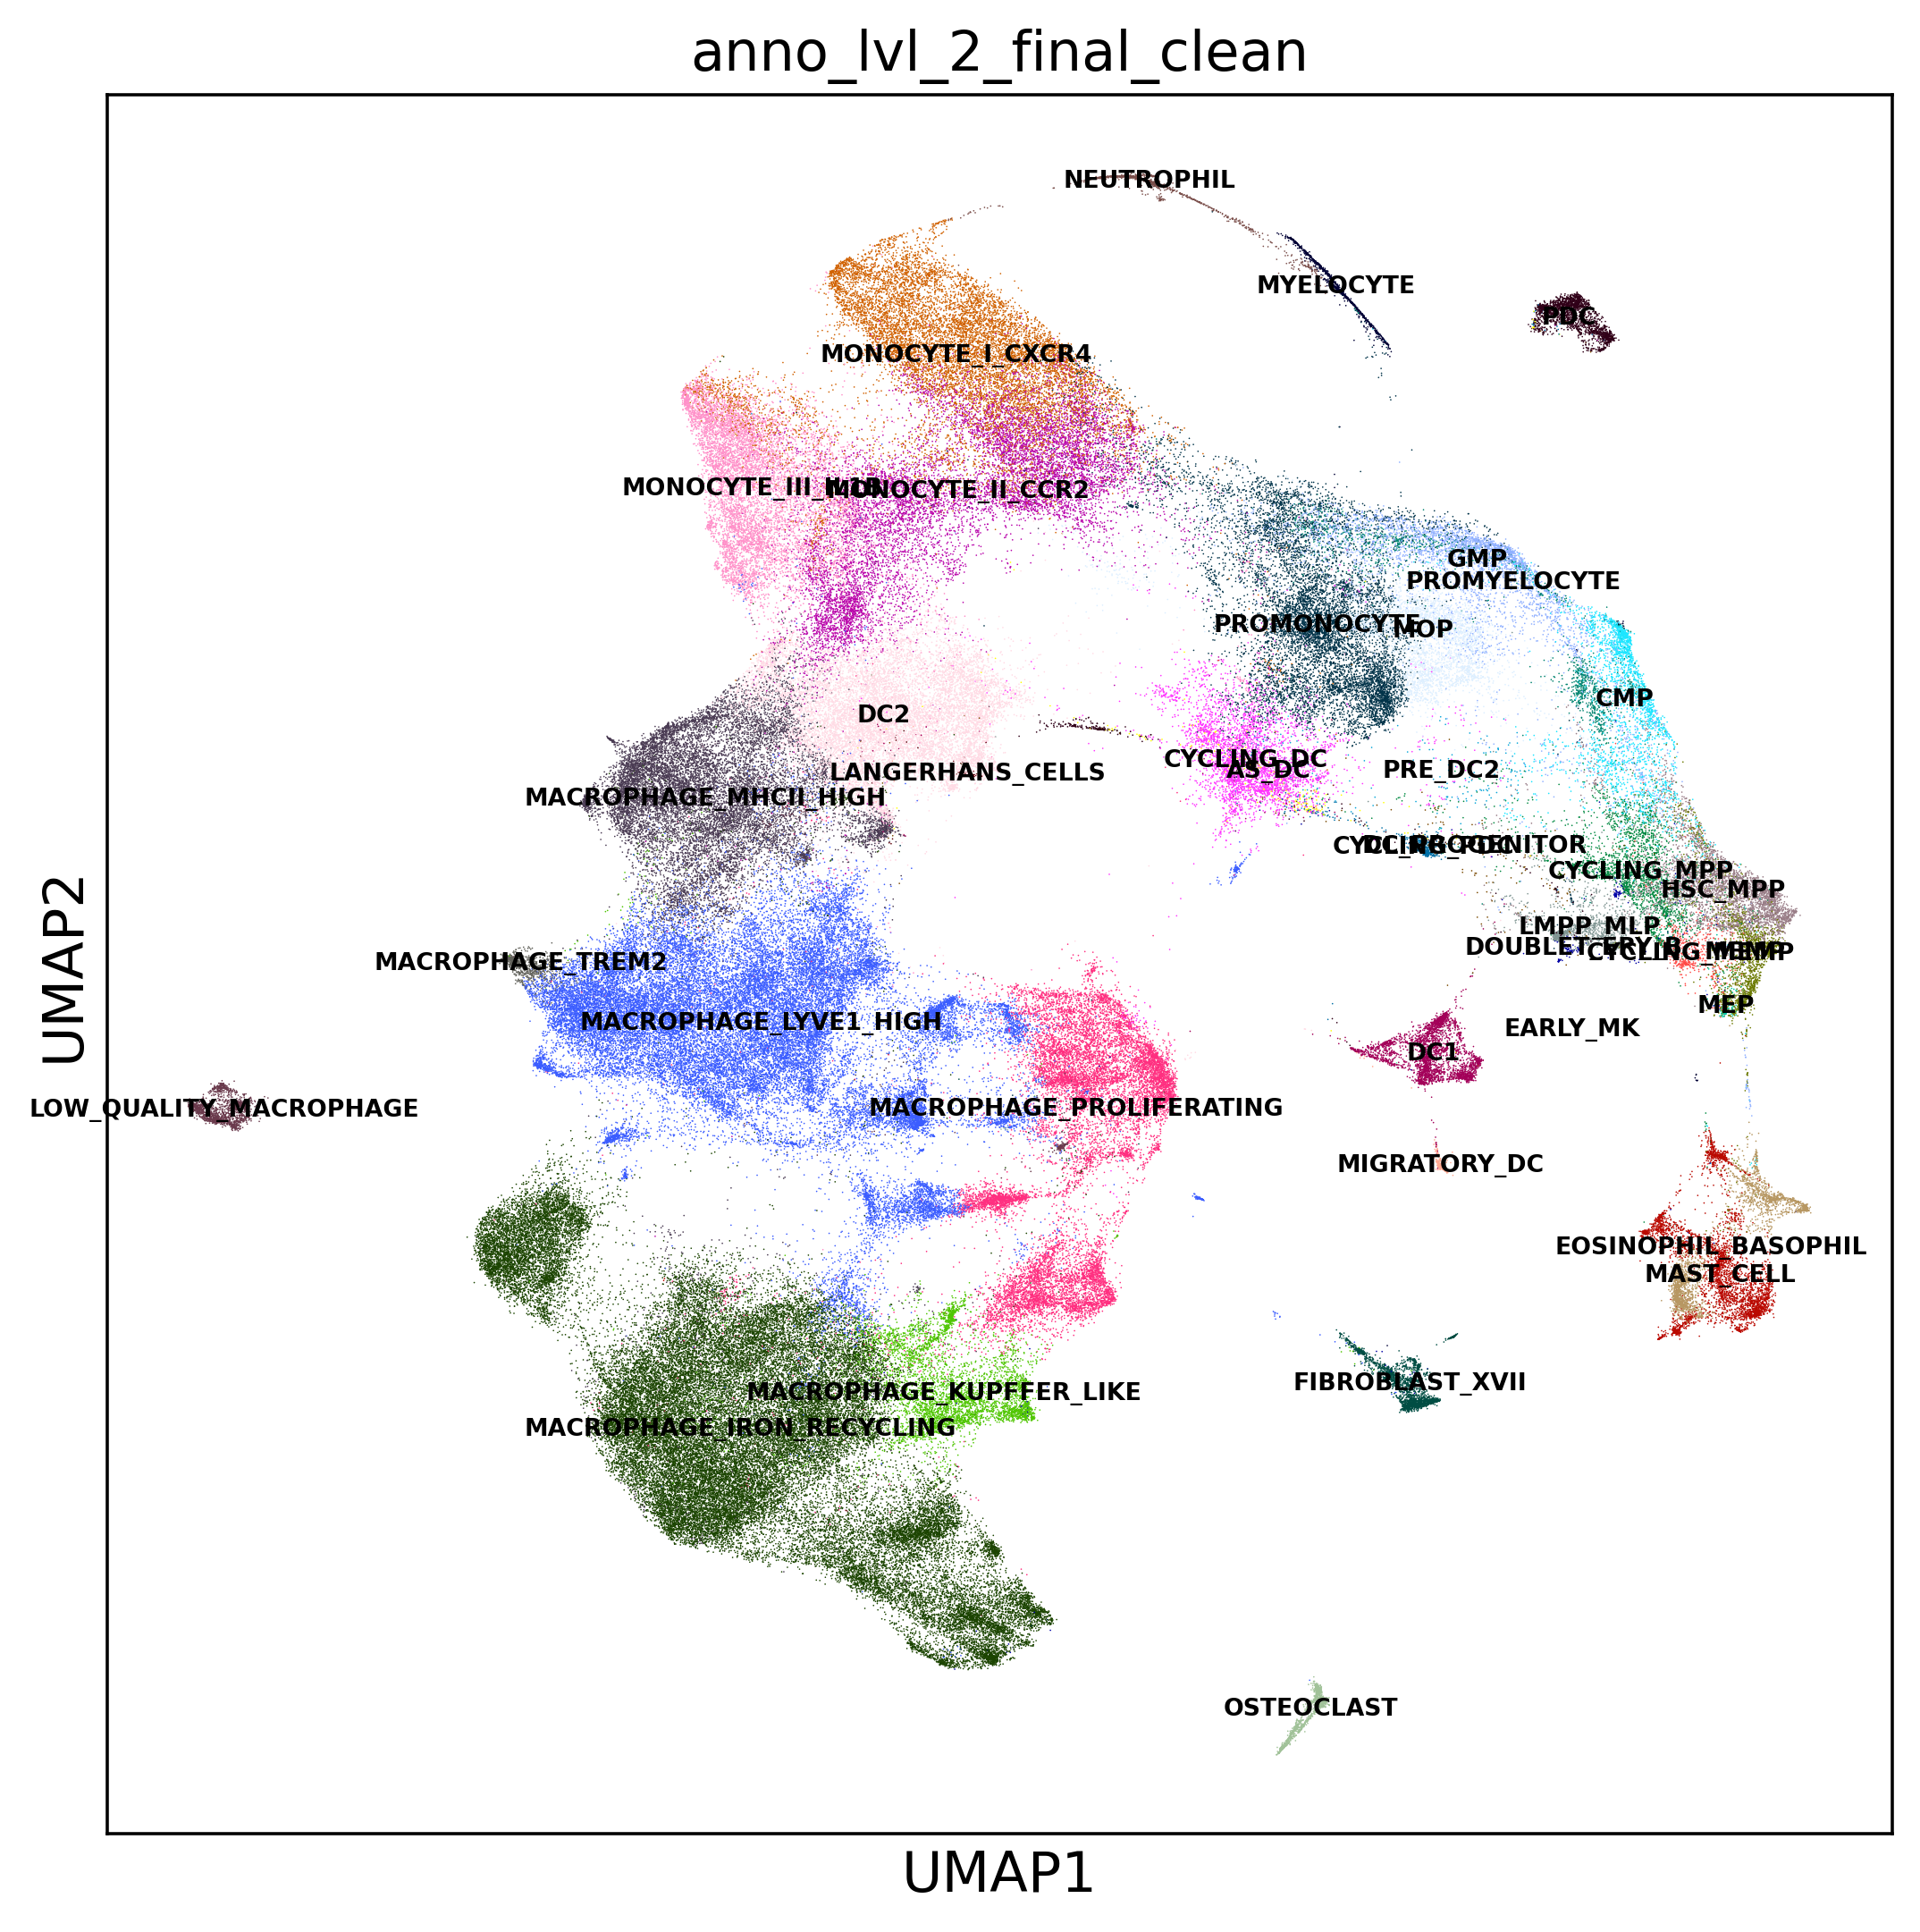

In [15]:
plt.rcParams["figure.figsize"] = [8,8]
sc.pl.umap(MYE,color=['anno_lvl_2_final_clean'],legend_loc='on data',ncols=1, legend_fontsize=6)

### expression of CXCR4, CCR2, IL1B within monocyte clusters

In [12]:
mono = MYE[MYE.obs['anno_lvl_2_final_clean'].isin(['MONOCYTE_I_CXCR4','MONOCYTE_II_CCR2','MONOCYTE_III_IL1B'])]

In [13]:
mono.obs['mono_anno'] = mono.obs['anno_lvl_2_final_clean'].astype('str')
mono.obs.loc[list(np.array(mono.obs['organ']=='BM') & np.array(mono.obs['mono_anno']=='MONOCYTE_II_CCR2')),'mono_anno'] = 'MONOCYTE_II_CCR2_BM'
mono.obs.loc[list(np.array(mono.obs['organ']=='BM') & np.array(mono.obs['mono_anno']=='MONOCYTE_I_CXCR4')),'mono_anno'] = 'MONOCYTE_I_CXCR4_BM'

Trying to set attribute `.obs` of view, copying.


In [14]:
mono.obs['mono_anno'] = mono.obs['mono_anno'].astype('category')
mono.obs['mono_anno'] = mono.obs['mono_anno'].cat.reorder_categories(['MONOCYTE_I_CXCR4','MONOCYTE_I_CXCR4_BM','MONOCYTE_II_CCR2_BM','MONOCYTE_II_CCR2','MONOCYTE_III_IL1B'])
# filter out CXCR4 monocytes from other organs
mono_filtered = mono[mono.obs['mono_anno'].isin(['MONOCYTE_I_CXCR4_BM','MONOCYTE_II_CCR2_BM','MONOCYTE_II_CCR2','MONOCYTE_III_IL1B'])]

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'file' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'predicted_doublets' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'uniform_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'uniform_label_expanded_merged' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'uniform_label_lvl0' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'organ' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Sample.lanes' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Sort_id' as categorical
Trying to

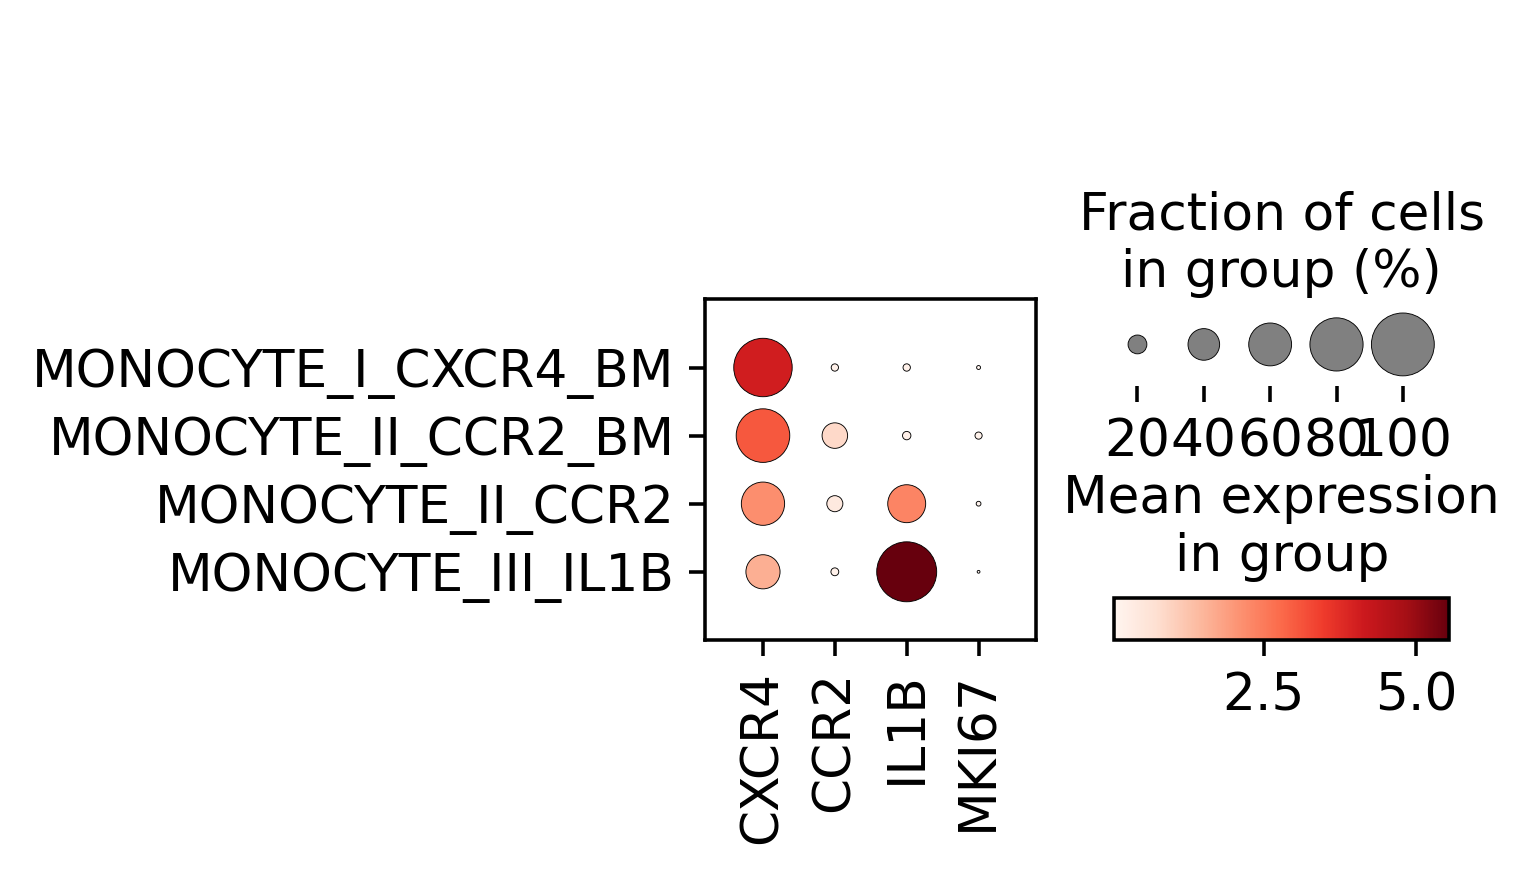

In [15]:
sc.pl.dotplot(mono_filtered, var_names = ['CXCR4','CCR2','IL1B','MKI67'], groupby = 'mono_anno', save = 'monocyte_marker_gene_patter.pdf')

# Ratio of CXCR4 monocyte / CCR2 monocyte in BM vs LI

In [16]:
obs['donor_organ_sort']=np.char.array(obs['donor'],unicode=True)+'_'+np.char.array(obs['organ'],unicode=True)+'_'+np.char.array(obs['Sort_id'],unicode=True)

In [17]:
counter_tot = Counter(obs['donor_organ_sort'])

In [18]:
mono = MYE[MYE.obs['anno_lvl_2_final_clean'].isin(['MONOCYTE_I_CXCR4','MONOCYTE_III_CCR2','MONOCYTE_II_IL1B'])]

In [101]:
adata_select = mono[mono.obs['organ'].isin(['BM','LI'])].copy()

In [102]:
adata_select.obs['donor_organ']=np.char.array(adata_select.obs['donor'],unicode=True)+'_'+np.char.array(adata_select.obs['organ'],unicode=True)
adata_select.obs['donor_organ']=adata_select.obs['donor_organ'].astype('category')

In [103]:
cc1 = pd.DataFrame(index =list(adata_select.obs['donor_organ'].cat.categories), columns = list(adata_select.obs['anno_lvl_2_final_clean'].cat.categories)+['total'])

In [104]:
for donor_organ in cc1.index:
    counter = Counter(adata_select[adata_select.obs['donor_organ']==donor_organ].obs['anno_lvl_2_final_clean'])
    
    for cell in cc1.columns[:-1]:
        cc1.loc[donor_organ,cell] = counter[cell]
    
    cc1.loc[donor_organ,'total']=sum(adata_select.obs['donor_organ']==donor_organ)
    #cluster_counter.loc['B1%',sample]=counterB1[sample] / counterB[sample]
cc1 = cc1.astype('int64')

In [106]:
cc1['age'] = lookup(cc1.index, adata_select.obs, 'donor_organ', 'age').astype('int64')
cc1['organ'] = [str(a).split('_')[1] for a in cc1.index]
bin_names = np.array(['7-9 pcw', '10-12 pcw', '13-15 pcw', '16-17 pcw']) # bin ages 
cc1['age_bin'] = bin_names[np.digitize(cc1['age'], [10, 13, 16])]
cc1['age_bin'] = cc1['age_bin'].astype('category').cat.reorder_categories(bin_names)
cc1['age_organ'] = cc1['age_bin'].astype('str') + '_' + cc1['organ'].astype('str')
cc1['CXCR4 / CCR2'] = cc1['MONOCYTE_I_CXCR4'] / cc1['MONOCYTE_III_CCR2']
#cc1 = cc1.loc[cc1['total'] >=50, :]

In [255]:
cc1

,MONOCYTE_III_CCR2,MONOCYTE_II_IL1B,MONOCYTE_I_CXCR4,total,age,organ,age_bin,age_organ,CXCR4 / CCR2
F21_BM,515,2,1080,1597,16,BM,16-17 pcw,16-17 pcw_BM,2.097087
F21_LI,19,77,7,103,16,LI,16-17 pcw,16-17 pcw_LI,0.368421
F22_LI,19,52,9,80,9,LI,7-9 pcw,7-9 pcw_LI,0.473684
F23_LI,14,106,35,155,11,LI,10-12 pcw,10-12 pcw_LI,2.500000
F29_BM,896,14,1847,2757,17,BM,16-17 pcw,16-17 pcw_BM,2.061384
F29_LI,34,137,15,186,17,LI,16-17 pcw,16-17 pcw_LI,0.441176
F30_BM,922,0,1606,2528,14,BM,13-15 pcw,13-15 pcw_BM,1.741866
F30_LI,151,780,62,993,14,LI,13-15 pcw,13-15 pcw_LI,0.410596
F32_LI,87,177,121,385,7,LI,7-9 pcw,7-9 pcw_LI,1.390805
F33_LI,32,280,122,434,9,LI,7-9 pcw,7-9 pcw_LI,3.812500


In [263]:
# limit LI samples to 12 pcw onwards to match BM
cc2 = cc1.loc[cc1['age']>11,:]

In [266]:
cc2['age_organ'] = cc2['age'].astype('str') + '_' + cc2['organ'].astype('str')

<ipython-input-266-1bb85beea48a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc2['age_organ'] = cc2['age'].astype('str') + '_' + cc2['organ'].astype('str')


In [268]:
cc3 = cc2.groupby(['age_organ']).agg('sum')
tmp= cc2.groupby(['age_organ']).first()
cc3['age']=tmp['age']
cc3['organ']=tmp['organ']
cc3['CXCR4 / CCR2'] = cc3['MONOCYTE_I_CXCR4'] / cc3['MONOCYTE_III_CCR2']

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


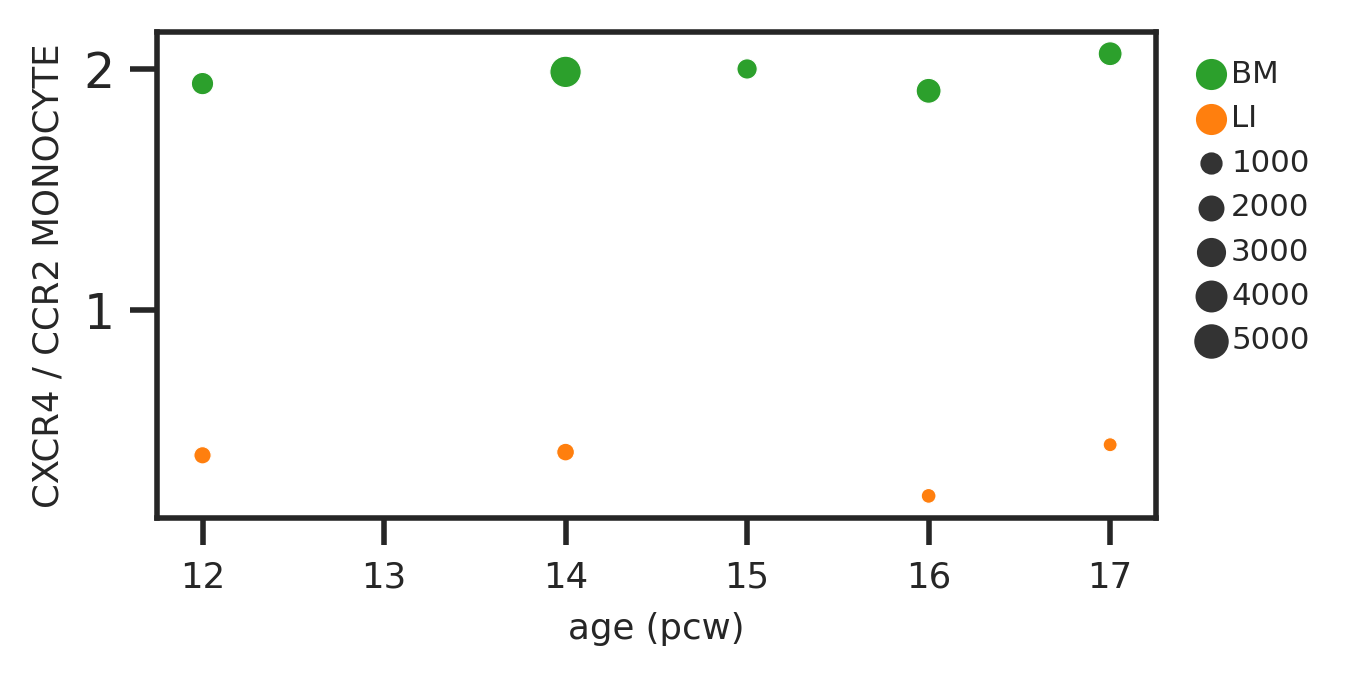

In [281]:
sb.set_theme(style='ticks')
fig, ax = plt.subplots(figsize=(4,2))
s = sb.scatterplot(cc3.loc[:,'age'], cc3.loc[:,'CXCR4 / CCR2'], hue=cc3.loc[:,'organ'],
                    size =np.array(cc3.loc[:,'total'], dtype='float'),
                   sizes=(10, 50),ax=ax,palette=organ_color_map)
#s.set(ylabel='CXCR4 / CCR2 MONOCYTE')
#s.set(xlabel='age (pcw)')
s.set_xlabel('age (pcw)',fontsize=8)
s.set_ylabel("CXCR4 / CCR2 MONOCYTE",fontsize=8)

plt.xticks(fontsize=8)

h,l = ax.get_legend_handles_labels()
l1 = ax.legend(loc='upper left',bbox_to_anchor=(1.02, 1),frameon=False, fontsize='xx-small')
plt.savefig(fig_path+'CXCR4toCCR2monocyte_ratio.pdf',bbox_inches='tight')

# Plot CXCL12 distribution within BM and LI

### Load all data

In [125]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [126]:
adata = adata[adata.obs_names.isin(obs.index)] # removed cells are maternal contaminants

In [127]:
adata.var_names_make_unique()
adata.raw = adata.copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [128]:
for col in obs:
    adata.obs[col] = obs[col] # use anno_lvl_2_final_clean

In [239]:
ct_len = len(set(adata.obs['anno_lvl_2_final_clean']))

In [240]:
df = pd.DataFrame(index = range(ct_len), columns = ['CXCL12','n_cell','organ','ct'])
df['ct']= list(set(adata.obs['anno_lvl_2_final_clean']))
df['organ']='BM'

In [241]:
for i in df.index:
    ct = df['ct'][i]
    organ = df['organ'][i]
    data_select = adata[np.array(adata.obs['anno_lvl_2_final_clean']==ct) & np.array(adata.obs['organ']==organ)]
    
    df.iloc[i,1]=data_select.shape[0]
    df.iloc[i,0]=np.mean(data_select[:,'CXCL12'].X)

/home/jovyan/my-conda-envs/skeleton/lib/python3.8/site-packages/scipy/sparse/base.py:581: RuntimeWarning: divide by zero encountered in true_divide
  return self.astype(np.float_)._mul_scalar(1./other)


In [243]:
# filter for main players - log expression >1, cell number > 20
df1 = df.loc[df['CXCL12']>1,:]
df1 = df1.loc[df1['n_cell']>10,:]

In [246]:
# remove doublet/low quality cells
df2 = df1.loc[~(df1['ct'].isin(['DOUBLETS_FIBRO_ERY','LOW_QUALITY_MACROPHAGE','LOW_QUALITY'])),:]

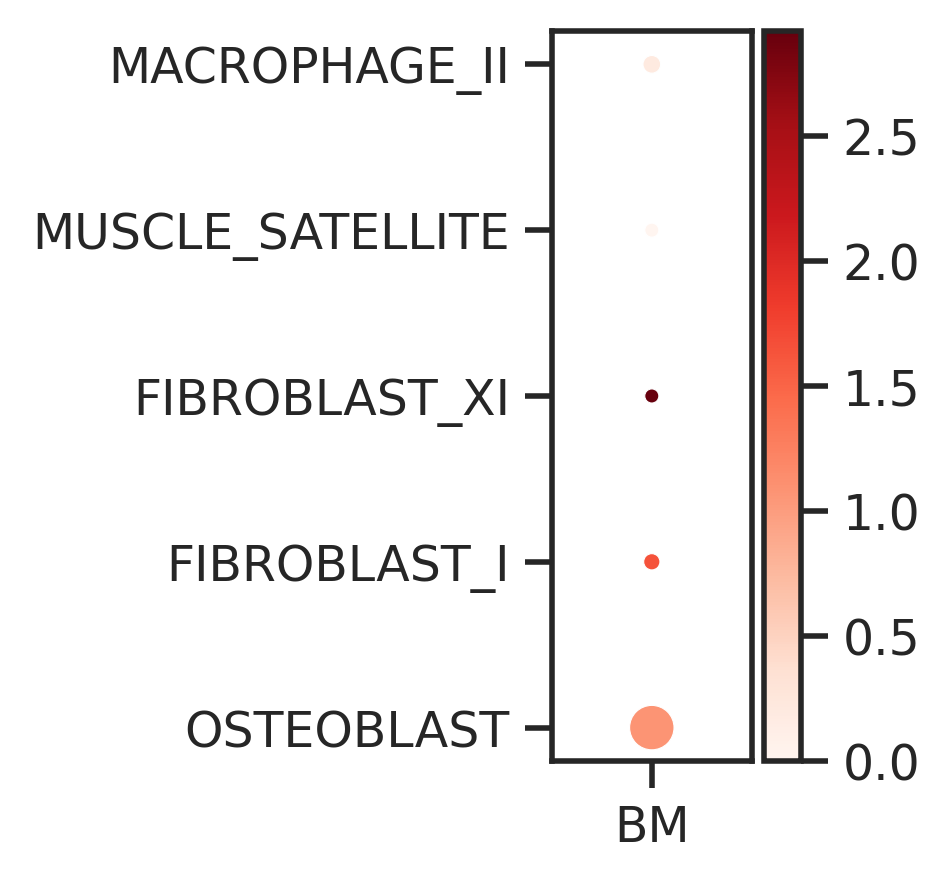

In [253]:
fig, ax = plt.subplots(figsize=(1,3))
s = sb.scatterplot(data=df2, x="organ",y= 'ct',hue="CXCL12",size='n_cell',palette='Reds', sizes=(10,100))
s.set(xlabel='')
s.set(ylabel='')

# add color bar 
norm = plt.Normalize(0, df2['CXCL12'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.savefig(fig_path+'monocyte_CXCL12.pdf',bbox_inches='tight')